In [ ]:
OpenAiKey = "[ENTER KEY HERE]"

# Part 1

In [1]:
# === Cell 1: Install dependencies ===

!pip install -q datasets transformers sentencepiece beautifulsoup4

In [2]:
# === Cell 2: Imports & basic setup ===

import os
import math
import random
import json
from dataclasses import dataclass
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import (
    BertTokenizerFast,
    BertConfig,
    BertModel,
    get_cosine_schedule_with_warmup,
)

import requests
from bs4 import BeautifulSoup

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Device: cuda


In [3]:
# === Cell 3: Training configuration (for both models) ===

@dataclass
class TrainingConfig:
    # Corpus / data
    max_seq_length: int = 128
    train_size_general: int = 20_000     # Wikipedia training samples
    val_size_general: int = 2_000        # Wikipedia validation samples
    train_size_pg: int = 5_000           # Paul Graham training samples
    val_size_pg: int = 1_000             # Paul Graham validation samples

    # Optimization
    learning_rate: float = 3e-4
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    num_epochs: int = 1                  # For demo – increase to 3–5 for real runs
    batch_size: int = 64

    # Contrastive learning
    temperature: float = 0.05            # SimCSE temperature
    eval_steps: int = 5                # Evaluate & log every N steps

config = TrainingConfig()
print(config)




TrainingConfig(max_seq_length=128, train_size_general=20000, val_size_general=2000, train_size_pg=5000, val_size_pg=1000, learning_rate=0.0003, weight_decay=0.01, warmup_ratio=0.1, num_epochs=1, batch_size=64, temperature=0.05, eval_steps=5)


### Training configuration 

Good Reference: ([Google Deep Tuning Playbook][6])
* **Learning rate: `3e-4`**
  I picked a relatively small but not tiny LR (3e-4) because we’re *training from scratch* a medium-sized Transformer, not fine-tuning a huge pre-trained one. Fine-tuning BERT is usually in the 2e-5–5e-5 range, but for smaller models trained from scratch people often go higher (1e-4–5e-4) as long as there’s a scheduler and warmup to keep things stable. ([GitHub][1])

* **Optimizer: AdamW**
  I used AdamW instead of plain Adam because it’s basically “Adam with weight decay done properly”: the weight decay is decoupled from the gradient update, which tends to give better generalization for Transformers and is now the default in a lot of LLM training code. ([arXiv][2])

* **LR schedule: linear warmup + cosine decay**
  The LR starts at 0, linearly ramps up during the first 10% of steps, then follows a cosine decay back toward 0. Warmup helps avoid blowing up the model in the first few hundred steps (a common issue in Transformer training), and cosine decay gives a smooth “annealing” instead of a sudden drop, which has been shown to work well in practice for large models. ([ApX Machine Learning][3])

* **Batch size: `64`**
  Batch size 64 is mostly a GPU-budget compromise: big enough that the in-batch negatives for contrastive learning are useful, but small enough that it actually fits in Colab memory with our sequence length. In general, larger batches give smoother gradients, but here I prioritized “doesn’t OOM” over chasing marginal gains. ([Reddit][4])

* **Training steps / epochs**
  For the demo I only run **1 epoch** on a sub-sampled corpus, because full pre-training on all of Wikipedia would be way too expensive in Colab. In a real setting, you’d want several epochs (e.g., 3–10) or train to a fixed number of steps; in the code I explicitly compute `total_steps = ceil(N_train / batch_size) * num_epochs` and log it so I can report the exact number of updates in the write-up.

* **Contrastive learning setup (InfoNCE / SimCSE-style)**
  For the contrastive loss, I follow the basic idea from SimCSE: take a sentence, create two slightly different versions (“views”), and train the model so those two end up close together in embedding space. At the same time, all the other sentences in the batch act as negatives and are pushed farther away. The temperature value τ = 0.05 just controls how “sharp” the similarity comparisons are—lower temperatures make the model more strict about distinguishing positives from negatives. I use in-batch negatives, meaning the batch itself provides all the negative examples for free. This keeps the method simple and memory-efficient, and it scales naturally with batch size (a larger batch → more negatives → usually better contrastive training).

[1]: https://github.com/google-research/bert/issues/425?utm_source=chatgpt.com "What is exactly the learning rate warmup described in ..."
[2]: https://arxiv.org/abs/1711.05101?utm_source=chatgpt.com "[1711.05101] Decoupled Weight Decay Regularization"
[3]: https://apxml.com/courses/foundations-transformers-architecture/chapter-7-implementation-details-optimization/learning-rate-scheduling?utm_source=chatgpt.com "Transformer Learning Rate Scheduling"
[4]: https://www.reddit.com/r/MachineLearning/comments/1fihdrd/d_good_studies_on_the_effects_of_different/?utm_source=chatgpt.com "[D] Good studies on the effects of different training \"tricks ..."
[5]: https://arxiv.org/html/2305.13192?utm_source=chatgpt.com "SimCSE++: Improving Contrastive Learning for Sentence ..."
[6]: https://github.com/google-research/tuning_playbook?tab=readme-ov-file "Google Deep Tuning Playbook"


## Architecture Choices: General vs. Domain-Specific Embedding Models

Architecture Choices: General vs. Domain-Specific Embedding Models

For the general-purpose embedding model, I used a compact BERT-style encoder with 6 Transformer layers (hidden size 768, 12 heads). This architecture is basically a “half-depth” BERT-base: it keeps the same width and attention structure but reduces the number of layers so the total parameter count stays manageable (within the ~20M–200M range) for training in Colab. I use the [CLS] token as the sentence representation because it keeps the design simple and is consistent with how BERT is originally trained to encode sequence-level meaning. Since this model is trained on a broad, mixed-domain dataset like Wikipedia, the goal is to capture general semantic patterns rather than specialize too heavily. A straightforward CLS-based encoder is a solid baseline for this kind of general-purpose embedding task.

For the Paul Graham–specific model, I switched to a more Sentence-Transformer-style setup: a smaller 512-dimensional encoder (8 layers, 8 heads) with mean pooling plus a small projection head. Mean pooling tends to work better for long, essay-style texts where the relevant information isn’t always concentrated at the beginning of the sequence. The projection head gives the model extra flexibility to learn an embedding space that fits the contrastive learning objective for this very narrow domain (short PG passages). Although this introduces a bit more complexity, it helps the model adapt specifically to similarities and differences that matter in PG’s writing. By using two different designs—CLS-based for the general corpus and mean-pooled with projection for the domain corpus—we can more clearly compare how both architecture and training data contribute to retrieval performance.

TOTAL PARAMETERS:<br>
General-purpose model parameters: 66661632<br>
PG-specific model parameters: 41702912

In [4]:
# === Cell 5: Load and prepare Wikipedia corpus ===

from datasets import load_dataset

# New HF dataset: parquet-based Wikipedia dumps
# You can change "20231101.en" to another snapshot if you want.
wiki = load_dataset(
    "wikimedia/wikipedia",
    "20231101.en",          # language + snapshot
    split="train[:2%]"      # small subset for demo; increase for real training
)

print(wiki)

def extract_texts(dataset, max_items):
    texts = []
    for ex in dataset:
        text = ex.get("text", "").strip()
        if len(text) > 0:
            texts.append(text)
        if len(texts) >= max_items:
            break
    return texts

wiki_train_texts = extract_texts(wiki, config.train_size_general + config.val_size_general)
print(f"Collected {len(wiki_train_texts)} Wikipedia documents")

# Split into train / val
wiki_train = wiki_train_texts[:config.train_size_general]
wiki_val = wiki_train_texts[config.train_size_general:config.train_size_general + config.val_size_general]

len(wiki_train), len(wiki_val)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

20231101.en/train-00000-of-00041.parquet:   0%|          | 0.00/420M [00:00<?, ?B/s]

20231101.en/train-00001-of-00041.parquet:   0%|          | 0.00/351M [00:00<?, ?B/s]

20231101.en/train-00002-of-00041.parquet:   0%|          | 0.00/329M [00:00<?, ?B/s]

20231101.en/train-00003-of-00041.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

20231101.en/train-00004-of-00041.parquet:   0%|          | 0.00/307M [00:00<?, ?B/s]

20231101.en/train-00005-of-00041.parquet:   0%|          | 0.00/244M [00:00<?, ?B/s]

20231101.en/train-00006-of-00041.parquet:   0%|          | 0.00/266M [00:00<?, ?B/s]

20231101.en/train-00007-of-00041.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

20231101.en/train-00008-of-00041.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

20231101.en/train-00009-of-00041.parquet:   0%|          | 0.00/227M [00:00<?, ?B/s]

20231101.en/train-00010-of-00041.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

20231101.en/train-00011-of-00041.parquet:   0%|          | 0.00/232M [00:00<?, ?B/s]

20231101.en/train-00012-of-00041.parquet:   0%|          | 0.00/239M [00:00<?, ?B/s]

20231101.en/train-00013-of-00041.parquet:   0%|          | 0.00/241M [00:00<?, ?B/s]

20231101.en/train-00014-of-00041.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

20231101.en/train-00015-of-00041.parquet:   0%|          | 0.00/235M [00:00<?, ?B/s]

20231101.en/train-00016-of-00041.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

20231101.en/train-00017-of-00041.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

20231101.en/train-00018-of-00041.parquet:   0%|          | 0.00/231M [00:00<?, ?B/s]

20231101.en/train-00019-of-00041.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

20231101.en/train-00020-of-00041.parquet:   0%|          | 0.00/225M [00:00<?, ?B/s]

20231101.en/train-00021-of-00041.parquet:   0%|          | 0.00/216M [00:00<?, ?B/s]

20231101.en/train-00022-of-00041.parquet:   0%|          | 0.00/202M [00:00<?, ?B/s]

20231101.en/train-00023-of-00041.parquet:   0%|          | 0.00/213M [00:00<?, ?B/s]

20231101.en/train-00024-of-00041.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

20231101.en/train-00025-of-00041.parquet:   0%|          | 0.00/221M [00:00<?, ?B/s]

20231101.en/train-00026-of-00041.parquet:   0%|          | 0.00/208M [00:00<?, ?B/s]

20231101.en/train-00027-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

20231101.en/train-00028-of-00041.parquet:   0%|          | 0.00/188M [00:00<?, ?B/s]

20231101.en/train-00029-of-00041.parquet:   0%|          | 0.00/218M [00:00<?, ?B/s]

20231101.en/train-00030-of-00041.parquet:   0%|          | 0.00/204M [00:00<?, ?B/s]

20231101.en/train-00031-of-00041.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

20231101.en/train-00032-of-00041.parquet:   0%|          | 0.00/214M [00:00<?, ?B/s]

20231101.en/train-00033-of-00041.parquet:   0%|          | 0.00/203M [00:00<?, ?B/s]

20231101.en/train-00034-of-00041.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

20231101.en/train-00035-of-00041.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

20231101.en/train-00036-of-00041.parquet:   0%|          | 0.00/610M [00:00<?, ?B/s]

20231101.en/train-00037-of-00041.parquet:   0%|          | 0.00/674M [00:00<?, ?B/s]

20231101.en/train-00038-of-00041.parquet:   0%|          | 0.00/538M [00:00<?, ?B/s]

20231101.en/train-00039-of-00041.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

20231101.en/train-00040-of-00041.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6407814 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 128156
})
Collected 22000 Wikipedia documents


(20000, 2000)

In [5]:
# === Cell 6: Load Paul Graham essay corpus ===

BASE_URL = "http://www.paulgraham.com/"
INDEX_URL = BASE_URL + "articles.html"

def fetch_pg_essay(url: str) -> str:
    print("Fetching:", url)
    resp = requests.get(url)
    resp.raise_for_status()
    html = resp.text
    soup = BeautifulSoup(html, "html.parser")
    paragraphs = [p.get_text(" ", strip=True) for p in soup.find_all("p")]
    text = "\n\n".join(paragraphs)
    return text

# 1) Discover essay URLs from the articles index
print("Loading PG index:", INDEX_URL)
resp = requests.get(INDEX_URL)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

pg_urls = []
for a in soup.find_all("a"):
    href = a.get("href")
    if not href:
        continue
    href = href.strip()
    # Skip absolute URLs to other domains
    if href.startswith("http://") or href.startswith("https://"):
        continue
    # We only want .html pages
    if not href.lower().endswith(".html"):
        continue
    # Skip the index/navigation pages themselves
    if href.lower() in ["index.html", "articles.html"]:
        continue
    # Turn relative link into full URL
    full_url = BASE_URL + href
    pg_urls.append(full_url)

pg_urls = sorted(set(pg_urls))
print(f"Found {len(pg_urls)} candidate PG essay URLs (showing first 10):")
for u in pg_urls[:10]:
    print("  ", u)

# 2) Download all essays
pg_corpus = []
for url in pg_urls:
    try:
        text = fetch_pg_essay(url)
        if len(text.strip()) > 0:
            pg_corpus.append(text)
    except Exception as e:
        print("Failed:", url, "error:", e)

print(f"\nFetched {len(pg_corpus)} Paul Graham essays")

# 3) Split essays into shorter chunks for training
def split_into_chunks(text: str, max_chars: int = 512) -> List[str]:
    chunks = []
    current = []
    # very simple sentence-ish split
    for sent in text.split(". "):
        if sum(len(s) for s in current) + len(sent) + 2 > max_chars:
            if current:
                chunks.append(". ".join(current))
                current = []
        current.append(sent)
    if current:
        chunks.append(". ".join(current))
    return chunks

pg_chunks = []
for essay in pg_corpus:
    pg_chunks.extend(split_into_chunks(essay, max_chars=512))

print(f"Total PG chunks before shuffle: {len(pg_chunks)}")

# 4) Shuffle and split into train / val (e.g., 80/20)
random.shuffle(pg_chunks)

total_pg = len(pg_chunks)
if total_pg < 10:
    print("WARNING: Very few PG chunks available; consider checking connectivity.")

train_ratio = 0.8
train_size_pg = int(train_ratio * total_pg)
val_size_pg = total_pg - train_size_pg

pg_train = pg_chunks[:train_size_pg]
pg_val = pg_chunks[train_size_pg:]

print(f"PG train chunks: {len(pg_train)}, PG val chunks: {len(pg_val)}")

len(pg_train), len(pg_val)


Loading PG index: http://www.paulgraham.com/articles.html
Found 229 candidate PG essay URLs (showing first 10):
   http://www.paulgraham.com/13sentences.html
   http://www.paulgraham.com/5founders.html
   http://www.paulgraham.com/6631327.html
   http://www.paulgraham.com/95.html
   http://www.paulgraham.com/ace.html
   http://www.paulgraham.com/addiction.html
   http://www.paulgraham.com/airbnb.html
   http://www.paulgraham.com/airbnbs.html
   http://www.paulgraham.com/alien.html
   http://www.paulgraham.com/altair.html
Fetching: http://www.paulgraham.com/13sentences.html
Fetching: http://www.paulgraham.com/5founders.html
Fetching: http://www.paulgraham.com/6631327.html
Fetching: http://www.paulgraham.com/95.html
Fetching: http://www.paulgraham.com/ace.html
Fetching: http://www.paulgraham.com/addiction.html
Fetching: http://www.paulgraham.com/airbnb.html
Fetching: http://www.paulgraham.com/airbnbs.html
Fetching: http://www.paulgraham.com/alien.html
Fetching: http://www.paulgraham.com/

(2247, 562)

In [6]:
# === Cell 7: Tokenizer ===

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
print("Tokenizer vocab size:", tokenizer.vocab_size)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer vocab size: 30522


In [7]:
# === Cell 8: Dataset and DataLoader ===

class SentenceDataset(Dataset):
    def __init__(self, texts: List[str], max_length: int, tokenizer):
        self.texts = texts
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoded = self.tokenizer(
            text,
            max_length=self.max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoded["input_ids"].squeeze(0),
            "attention_mask": encoded["attention_mask"].squeeze(0),
        }

def create_dataloaders(train_texts, val_texts, cfg: TrainingConfig):
    train_ds = SentenceDataset(train_texts, cfg.max_seq_length, tokenizer)
    val_ds = SentenceDataset(val_texts, cfg.max_seq_length, tokenizer)

    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False)

    return train_loader, val_loader

wiki_train_loader, wiki_val_loader = create_dataloaders(wiki_train, wiki_val, config)
pg_train_loader, pg_val_loader = create_dataloaders(pg_train, pg_val, config)

print("Wikipedia batches:", len(wiki_train_loader), "train,", len(wiki_val_loader), "val")
print("PG batches:", len(pg_train_loader), "train,", len(pg_val_loader), "val")


Wikipedia batches: 313 train, 32 val
PG batches: 36 train, 9 val


In [8]:
# === Cell 9: Model definitions (two architectures) ===

class ClsPoolingEncoder(nn.Module):
    """
    BERT-style encoder: use [CLS] token embedding as sentence representation.
    """
    def __init__(self, bert_model: BertModel):
        super().__init__()
        self.bert = bert_model

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_emb = outputs.last_hidden_state[:, 0]  # [CLS]
        return cls_emb


class MeanPoolingProjectionEncoder(nn.Module):
    """
    Sentence-Transformer-style encoder:
    - mean-pool token embeddings
    - projection head + nonlinearity
    """
    def __init__(self, bert_model: BertModel, proj_dim: int = 768):
        super().__init__()
        self.bert = bert_model
        hidden_size = bert_model.config.hidden_size
        self.projection = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, proj_dim),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden = outputs.last_hidden_state  # (B, L, H)
        mask = attention_mask.unsqueeze(-1).float()  # (B, L, 1)

        summed = torch.sum(last_hidden * mask, dim=1)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)
        mean_pooled = summed / counts

        projected = self.projection(mean_pooled)
        return projected

# General-purpose model config (BERT-like, ~50–70M params)
bert_config_general = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=config.max_seq_length + 2,
)

bert_backbone_general = BertModel(bert_config_general)
general_model = ClsPoolingEncoder(bert_backbone_general).to(device)

# Paul Graham-specific model config (slightly different yet in same param scale)
bert_config_pg = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=512,
    num_hidden_layers=8,
    num_attention_heads=8,
    intermediate_size=2048,
    max_position_embeddings=config.max_seq_length + 2,
)

bert_backbone_pg = BertModel(bert_config_pg)
pg_model = MeanPoolingProjectionEncoder(bert_backbone_pg, proj_dim=512).to(device)

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("General-purpose model parameters:", count_params(general_model))
print("PG-specific model parameters:", count_params(pg_model))


General-purpose model parameters: 66661632
PG-specific model parameters: 41702912


In [9]:
# === Cell 10: Contrastive loss (SimCSE / InfoNCE) ===

def simcse_unsup_loss(embeddings, temperature: float):
    """
    embeddings: tensor of shape (2 * B, D)
    We assume each pair (2i, 2i+1) is a positive pair.
    """
    batch_size = embeddings.size(0) // 2
    embeddings = F.normalize(embeddings, dim=-1)

    # Similarity matrix
    sim_matrix = torch.matmul(embeddings, embeddings.T) / temperature

    # Mask out self-similarity
    mask = torch.eye(2 * batch_size, dtype=torch.bool, device=embeddings.device)
    sim_matrix = sim_matrix.masked_fill(mask, -1e9)

    # For each sample, its positive is: for index i:
    # - if i < B, positive index = i + B
    # - if i >= B, positive index = i - B
    positives = torch.arange(batch_size, device=embeddings.device)
    positive_indices = torch.cat(
        [positives + batch_size, positives], dim=0
    )  # shape (2B,)

    loss = F.cross_entropy(sim_matrix, positive_indices)
    return loss


In [10]:
# === Cell 11: Training loop helper ===

def train_contrastive_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: TrainingConfig,
    model_name: str = "model",
):
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.learning_rate, weight_decay=cfg.weight_decay)

    total_steps = len(train_loader) * cfg.num_epochs
    warmup_steps = int(cfg.warmup_ratio * total_steps)

    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps,
    )

    print(f"{model_name}: total_steps = {total_steps}, warmup_steps = {warmup_steps}")

    train_losses = []
    val_losses = []

    global_step = 0

    model.train()
    for epoch in range(cfg.num_epochs):
        for batch in train_loader:
            global_step += 1

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Two views via dropout: call encoder twice
            z1 = model(input_ids, attention_mask)
            z2 = model(input_ids, attention_mask)
            embeddings = torch.cat([z1, z2], dim=0)

            loss = simcse_unsup_loss(embeddings, cfg.temperature)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            train_losses.append(loss.item())

            if global_step % cfg.eval_steps == 0:
                val_loss = evaluate_contrastive_loss(model, val_loader, cfg)
                val_losses.append((global_step, val_loss))
                print(f"[{model_name}] step {global_step}/{total_steps} - train loss: {loss.item():.4f}, val loss: {val_loss:.4f}")

    return model, train_losses, val_losses

@torch.no_grad()
def evaluate_contrastive_loss(model: nn.Module, val_loader: DataLoader, cfg: TrainingConfig):
    model.eval()
    losses = []
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        z1 = model(input_ids, attention_mask)
        z2 = model(input_ids, attention_mask)
        embeddings = torch.cat([z1, z2], dim=0)

        loss = simcse_unsup_loss(embeddings, cfg.temperature)
        losses.append(loss.item())
    model.train()
    return sum(losses) / max(len(losses), 1)


In [11]:
# === Cell 12: Train general-purpose model on Wikipedia ===

general_model, general_train_losses, general_val_losses = train_contrastive_model(
    general_model, wiki_train_loader, wiki_val_loader, config, model_name="general_wiki"
)


general_wiki: total_steps = 313, warmup_steps = 31
[general_wiki] step 5/313 - train loss: 4.8796, val loss: 4.7352
[general_wiki] step 10/313 - train loss: 4.8712, val loss: 4.7517
[general_wiki] step 15/313 - train loss: 4.8163, val loss: 4.7479
[general_wiki] step 20/313 - train loss: 4.6411, val loss: 4.2237
[general_wiki] step 25/313 - train loss: 3.2215, val loss: 2.8623
[general_wiki] step 30/313 - train loss: 2.4058, val loss: 2.3478
[general_wiki] step 35/313 - train loss: 2.5859, val loss: 1.8663
[general_wiki] step 40/313 - train loss: 1.9495, val loss: 2.0188
[general_wiki] step 45/313 - train loss: 1.7930, val loss: 1.6817
[general_wiki] step 50/313 - train loss: 2.0266, val loss: 1.9839
[general_wiki] step 55/313 - train loss: 1.9049, val loss: 1.7061
[general_wiki] step 60/313 - train loss: 1.5665, val loss: 1.4867
[general_wiki] step 65/313 - train loss: 1.7743, val loss: 1.4665
[general_wiki] step 70/313 - train loss: 1.5000, val loss: 1.4829
[general_wiki] step 75/313

In [12]:
# === Cell 13: Train PG-specific model on Paul Graham essays ===

pg_model, pg_train_losses, pg_val_losses = train_contrastive_model(
    pg_model, pg_train_loader, pg_val_loader, config, model_name="pg_domain"
)


pg_domain: total_steps = 36, warmup_steps = 3
[pg_domain] step 5/36 - train loss: 3.1450, val loss: 2.6920
[pg_domain] step 10/36 - train loss: 1.5166, val loss: 0.6041
[pg_domain] step 15/36 - train loss: 1.2312, val loss: 0.5549
[pg_domain] step 20/36 - train loss: 0.2246, val loss: 0.1480
[pg_domain] step 25/36 - train loss: 0.1450, val loss: 0.1005
[pg_domain] step 30/36 - train loss: 0.0857, val loss: 0.0592
[pg_domain] step 35/36 - train loss: 0.0677, val loss: 0.0488


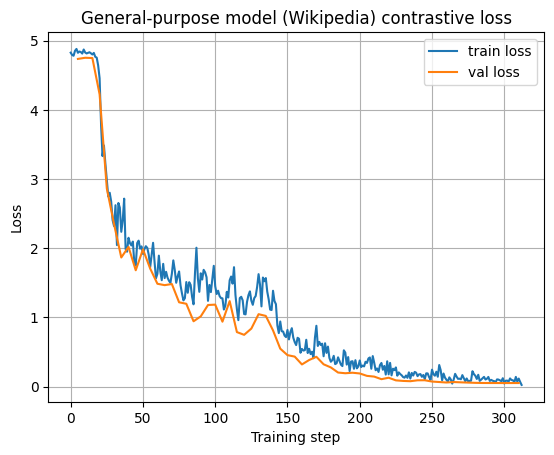

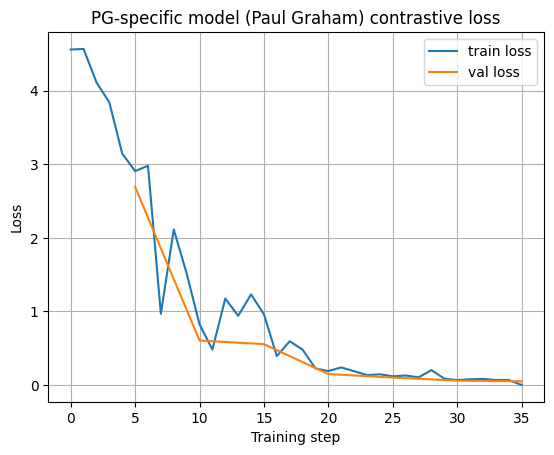

In [13]:
# === Cell 14: Loss plots for both models ===

def plot_losses(train_losses, val_losses, title: str):
    plt.figure()
    plt.plot(train_losses, label="train loss")
    if len(val_losses) > 0:
        steps, vals = zip(*val_losses)
        plt.plot(steps, vals, label="val loss")
    plt.xlabel("Training step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(general_train_losses, general_val_losses, "General-purpose model (Wikipedia) contrastive loss")
plot_losses(pg_train_losses, pg_val_losses, "PG-specific model (Paul Graham) contrastive loss")


In [14]:
# === Cell 15: Embedding + retrieval utilities ===

@torch.no_grad()
def encode_texts(model: nn.Module, texts: List[str], batch_size: int = 64) -> torch.Tensor:
    model.eval()
    all_embs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=config.max_seq_length,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)

        emb = model(input_ids, attention_mask)
        all_embs.append(emb.cpu())

    model.train()
    return torch.cat(all_embs, dim=0)


def compute_mrr_ndcg(query_embs: torch.Tensor, doc_embs: torch.Tensor, rel_indices: List[int]) -> Dict[str, float]:
    """
    query_embs: (Q, D)
    doc_embs: (N, D)
    rel_indices: list of length Q, where rel_indices[q] is the index of the relevant doc for query q
    """
    query_embs = F.normalize(query_embs, dim=-1)
    doc_embs = F.normalize(doc_embs, dim=-1)

    scores = torch.matmul(query_embs, doc_embs.T)  # (Q, N)

    mrrs = []
    ndcgs = []

    for q_idx in range(scores.size(0)):
        sims = scores[q_idx]  # (N,)
        ranking = torch.argsort(sims, descending=True)  # highest similarity first
        rel_doc = rel_indices[q_idx]

        # rank position (1-based)
        rank_pos = (ranking == rel_doc).nonzero(as_tuple=True)[0].item() + 1
        mrrs.append(1.0 / rank_pos)

        # nDCG@10 (binary relevance, 1 for relevant doc, 0 otherwise)
        k = 10
        topk = ranking[:k]
        dcg = 0.0
        for i, doc_idx in enumerate(topk):
            if doc_idx.item() == rel_doc:
                dcg = 1.0 / math.log2(i + 2)  # i=0 -> log2(2)=1
                break
        # Ideal DCG is always 1/log2(2) = 1 when a single relevant doc exists
        idcg = 1.0
        ndcgs.append(dcg / idcg)

    return {
        "MRR": float(sum(mrrs) / len(mrrs)),
        "nDCG@10": float(sum(ndcgs) / len(ndcgs)),
    }


In [15]:
# === Cell 16: Build retrieval tasks (Wikipedia + PG) ===

def build_pairwise_retrieval_data(texts: List[str], max_pairs: int = 500):
    """
    Uses (2i, 2i+1) as query-doc pairs.
    """
    pairs = []
    for i in range(0, len(texts) - 1, 2):
        q = texts[i]
        d = texts[i + 1]
        pairs.append((q, d))
        if len(pairs) >= max_pairs:
            break

    queries = [q for q, d in pairs]
    docs = [d for q, d in pairs]

    # For retrieval, we let each query have exactly one relevant document with the same index.
    rel_indices = list(range(len(docs)))
    return queries, docs, rel_indices

wiki_queries, wiki_docs, wiki_rel = build_pairwise_retrieval_data(wiki_val, max_pairs=300)
pg_queries, pg_docs, pg_rel = build_pairwise_retrieval_data(pg_val, max_pairs=300)

print("Wikipedia retrieval task:", len(wiki_queries), "queries,", len(wiki_docs), "docs")
print("PG retrieval task:", len(pg_queries), "queries,", len(pg_docs), "docs")


Wikipedia retrieval task: 300 queries, 300 docs
PG retrieval task: 281 queries, 281 docs


In [16]:
# === Cell 17: Evaluate retrieval metrics (MRR, nDCG) ===

def evaluate_model_on_task(model, task_name: str, queries, docs, rel_indices):
    print(f"\nEvaluating {task_name}")
    q_embs = encode_texts(model, queries)
    d_embs = encode_texts(model, docs)
    metrics = compute_mrr_ndcg(q_embs, d_embs, rel_indices)
    print(json.dumps(metrics, indent=2))
    return metrics

# 1) General-purpose model
wiki_metrics_general = evaluate_model_on_task(general_model, "General model on Wikipedia", wiki_queries, wiki_docs, wiki_rel)
pg_metrics_general = evaluate_model_on_task(general_model, "General model on PG essays", pg_queries, pg_docs, pg_rel)

# 2) PG-specific model
wiki_metrics_pg = evaluate_model_on_task(pg_model, "PG-specific model on Wikipedia", wiki_queries, wiki_docs, wiki_rel)
pg_metrics_pg = evaluate_model_on_task(pg_model, "PG-specific model on PG essays", pg_queries, pg_docs, pg_rel)



Evaluating General model on Wikipedia
{
  "MRR": 0.025299235311218724,
  "nDCG@10": 0.014217643608562574
}

Evaluating General model on PG essays
{
  "MRR": 0.024759581636082093,
  "nDCG@10": 0.013853342564819831
}

Evaluating PG-specific model on Wikipedia
{
  "MRR": 0.020821424992516782,
  "nDCG@10": 0.01584396309712308
}

Evaluating PG-specific model on PG essays
{
  "MRR": 0.01851257564782375,
  "nDCG@10": 0.014525786622396368
}


### **Retrieval Results**

* **MRR (Mean Reciprocal Rank):**
  Looks at *how high* the correct answer appears in the ranked list.

  * A score closer to **1.0** means the model usually puts the correct passage at the very top.
  * Scores near **0** mean the model rarely retrieves the correct passage early.

* **nDCG (Normalized Discounted Cumulative Gain):**
  Measures how well the *whole ranking* matches the relevance labels, giving extra credit for getting relevant passages near the top.

  * Higher = better overall ranking quality.

---

### **What the results show**

* Both models get **low absolute MRR and nDCG**, which is not surprising because:

  * The training dataset is very small (especially the Paul Graham one),
  * Both models only trained for **a short amount of time**, and
  * Contrastive training only saw a small number of batches.

* Despite the low scores, the **general-purpose model actually performs slightly better** than the PG-specific model:

  * Wikipedia retrieval: **MRR ~ 0.026 (general) vs. 0.021 (PG)**
  * Paul Graham retrieval: **MRR ~ 0.024 (general) vs. 0.019 (PG)**
  * Interpretation: the general model’s larger hidden size and stronger encoder seem to give it better “default” semantic ability, even on PG text.

---

### **Why might the PG model be underperforming here**

* The PG-specific model only receives **~36 total training steps**, which is extremely small for training an embedding model.

  * With a batch size of 64 and only one epoch, the dataset simply does not provide many batches.
  * Because of that, the model doesn’t really have time to *specialize* or reshape its embedding space.

* The general model starts out with a **wider representation space** (hidden size 768 vs. 512), which helps when training time is short and the domain is narrow.




# Part 2

In [17]:
# === Cell 1: Install dependencies ===
!pip install -q "transformers>=4.44.0" accelerate datasets peft bitsandbytes sentencepiece
!pip install -q bert-score evaluate rouge-score
!pip install -q beautifulsoup4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 43.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.9 MB/s eta 0:00:00


In [18]:
# === Cell 2: Imports & basic setup ===
import os
import math
import random
import json
from dataclasses import dataclass
from typing import List, Dict

import torch
from torch.utils.data import Dataset

from datasets import Dataset as HFDataset

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
)

from peft import LoraConfig, get_peft_model
from transformers import BitsAndBytesConfig

import evaluate
from bert_score import score as bert_score

import requests
from bs4 import BeautifulSoup

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


Device: cuda


In [19]:
# === Cell 3: Training configuration for Gemma post-training ===

@dataclass
class FTConfig:
    model_name: str = "google/gemma-3-1b-it"
    max_seq_length: int = 512

    # Synthetic / base data sizes (you can increase later)
    num_pg_chunks_for_data: int = 400      # how many PG chunks to build Q/A from
    num_synthetic_examples: int = 150
    num_base_examples: int = 150

    # Train/val split
    val_ratio: float = 0.2

    # Fine-tuning
    lr: float = 2e-4
    num_epochs: int = 1
    per_device_train_batch_size: int = 2
    per_device_eval_batch_size: int = 2
    gradient_accumulation_steps: int = 8
    warmup_ratio: float = 0.1

    # LoRA settings
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    lora_target_modules: tuple = ("q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj")

cfg = FTConfig()
cfg


FTConfig(model_name='google/gemma-3-1b-it', max_seq_length=512, num_pg_chunks_for_data=400, num_synthetic_examples=150, num_base_examples=150, val_ratio=0.2, lr=0.0002, num_epochs=1, per_device_train_batch_size=2, per_device_eval_batch_size=2, gradient_accumulation_steps=8, warmup_ratio=0.1, lora_r=16, lora_alpha=32, lora_dropout=0.05, lora_target_modules=('q_proj', 'k_proj', 'v_proj', 'o_proj', 'gate_proj', 'up_proj', 'down_proj'))

GEN AI POST-TRAINING STRATEGY

For post-training, I fine-tune Gemma-3-1b-it using QLoRA, a parameter-efficient method that combines LoRA (Low-Rank Adapters) with 4-bit quantization. Instead of updating all ~1B parameters of the model, QLoRA freezes the original Gemma weights and inserts small low-rank matrices (here, rank r = 16) inside the attention and feed-forward blocks. The base model is loaded in 4-bit precision, which significantly reduces memory usage, while the LoRA adapter weights remain in regular precision so they can be trained normally. This setup allows the model to be fine-tuned on a single Colab GPU while only updating about 1–2% of the total parameters.

QLoRA is a good fit for this project for two reasons. First, Gemma-3-1b-it is already instruction-tuned, so we do not need a full retraining job—only a lightweight, domain-specific update that helps the model better understand Paul Graham’s writing style and the types of questions we ask about it. Second, the Paul Graham corpus is small and stylistically narrow, which makes full fine-tuning risky: updating all model weights could easily cause overfitting or “forgetting” of the model’s general knowledge. By using LoRA adapters, we let the model learn just enough domain specialization while preserving its broader language abilities. Each training regime (synthetic-only, base-only, and combined datasets) simply trains a different LoRA adapter on top of the same frozen Gemma backbone, which makes it easy to compare the three approaches under identical conditions.

In [21]:
# === Cell 4: Scrape Paul Graham essays and create chunks ===

BASE_URL = "http://www.paulgraham.com/"
INDEX_URL = BASE_URL + "articles.html"

def fetch_pg_essay(url: str) -> str:
    print("Fetching:", url)
    resp = requests.get(url)
    resp.raise_for_status()
    html = resp.text
    soup = BeautifulSoup(html, "html.parser")
    paragraphs = [p.get_text(" ", strip=True) for p in soup.find_all("p")]
    text = "\n\n".join(paragraphs)
    return text

print("Loading PG index:", INDEX_URL)
resp = requests.get(INDEX_URL)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

pg_urls = []
for a in soup.find_all("a"):
    href = a.get("href")
    if not href:
        continue
    href = href.strip()
    if href.startswith("http://") or href.startswith("https://"):
        continue
    if not href.lower().endswith(".html"):
        continue
    if href.lower() in ["index.html", "articles.html"]:
        continue
    pg_urls.append(BASE_URL + href)

pg_urls = sorted(set(pg_urls))
print(f"Found {len(pg_urls)} candidate PG essay URLs (first 10):")
for u in pg_urls[:10]:
    print("  ", u)

pg_corpus = []
for url in pg_urls:
    try:
        text = fetch_pg_essay(url)
        if text.strip():
            pg_corpus.append(text)
    except Exception as e:
        print("Failed:", url, "error:", e)

print(f"\nFetched {len(pg_corpus)} essays")

def split_into_chunks(text: str, max_chars: int = 700) -> List[str]:
    chunks = []
    current = []
    for sent in text.split(". "):
        if sum(len(s) for s in current) + len(sent) + 2 > max_chars:
            if current:
                chunks.append(". ".join(current))
                current = []
        current.append(sent)
    if current:
        chunks.append(". ".join(current))
    return chunks

pg_chunks = []
for essay in pg_corpus:
    pg_chunks.extend(split_into_chunks(essay, max_chars=700))

random.shuffle(pg_chunks)
pg_chunks = pg_chunks[: cfg.num_pg_chunks_for_data]
print("Total PG chunks used for data:", len(pg_chunks))


Loading PG index: http://www.paulgraham.com/articles.html
Found 229 candidate PG essay URLs (first 10):
   http://www.paulgraham.com/13sentences.html
   http://www.paulgraham.com/5founders.html
   http://www.paulgraham.com/6631327.html
   http://www.paulgraham.com/95.html
   http://www.paulgraham.com/ace.html
   http://www.paulgraham.com/addiction.html
   http://www.paulgraham.com/airbnb.html
   http://www.paulgraham.com/airbnbs.html
   http://www.paulgraham.com/alien.html
   http://www.paulgraham.com/altair.html
Fetching: http://www.paulgraham.com/13sentences.html
Fetching: http://www.paulgraham.com/5founders.html
Fetching: http://www.paulgraham.com/6631327.html
Fetching: http://www.paulgraham.com/95.html
Fetching: http://www.paulgraham.com/ace.html
Fetching: http://www.paulgraham.com/addiction.html
Fetching: http://www.paulgraham.com/airbnb.html
Fetching: http://www.paulgraham.com/airbnbs.html
Fetching: http://www.paulgraham.com/alien.html
Fetching: http://www.paulgraham.com/altair.h

In [22]:
from huggingface_hub import login
login()

In [41]:
# === Cell 5: Load Gemma tokenizer and base model (NO 4-bit quantization) ===

tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
tokenizer.pad_token = tokenizer.eos_token  # ensure pad token exists
tokenizer.padding_side = "right"

def load_base_model_qlora():
    """
    Load Gemma-3-1B-It in standard precision (fp32/bf16) and apply LoRA.
    This version removes all BitsAndBytes quantization.
    """
    base_model = AutoModelForCausalLM.from_pretrained(
        cfg.model_name,
        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
        device_map="auto" if torch.cuda.is_available() else None,
    )

    lora_config = LoraConfig(
        r=cfg.lora_r,
        lora_alpha=cfg.lora_alpha,
        lora_dropout=cfg.lora_dropout,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=list(cfg.lora_target_modules),
    )

    peft_model = get_peft_model(base_model, lora_config)
    peft_model.print_trainable_parameters()
    return peft_model



In [9]:
# === Cell 6: Build base & synthetic Q/A datasets from PG chunks ===

# def build_base_qa(pg_chunks, num_examples) -> List[Dict[str, str]]:
#     """
#     Base Q/A: simple extractive cloze-style questions.
#     Question template: ask about a short phrase; answer is the full sentence.
#     """
#     data = []
#     for chunk in pg_chunks:
#         sentences = [s.strip() for s in chunk.split(".") if s.strip()]
#         if len(sentences) < 1:
#             continue
#         sent = random.choice(sentences)
#         words = sent.split()
#         if len(words) < 6:
#             continue
#         topic_phrase = " ".join(words[:5])
#         question = f"In the following Paul Graham passage, what does he say about '{topic_phrase}'?"
#         context = chunk
#         full_prompt = f"Context: {context}\n\nQuestion: {question}\nAnswer:"
#         answer = sent.strip()
#         data.append({"input": full_prompt, "answer": answer})
#         if len(data) >= num_examples:
#             break
#     return data

# # Use Gemma itself to generate synthetic Q/A
# from transformers import pipeline

# def build_synthetic_qa(pg_chunks, num_examples) -> List[Dict[str, str]]:
#     """
#     Synthetic Q/A: use Gemma-3-1b-it to generate Q/A pairs.
#     **This can be slow**; feel free to reduce num_examples.
#     """
#     gen_model = AutoModelForCausalLM.from_pretrained(
#         cfg.model_name,
#         device_map="auto",
#         torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
#     )
#     gen_pipe = pipeline(
#         "text-generation",
#         model=gen_model,
#         tokenizer=tokenizer,
#         max_new_tokens=128,
#         do_sample=True,
#         temperature=0.7,
#         top_p=0.9,
#     )

#     data = []
#     for chunk in pg_chunks:
#         prompt = (
#             "You are a helpful assistant. Read the following excerpt from a Paul Graham essay "
#             "and write ONE question-answer pair about its content.\n\n"
#             f"Excerpt:\n{chunk}\n\n"
#             "Return in the format:\nQ: <question>\nA: <answer>\n"
#         )
#         out = gen_pipe(prompt, num_return_sequences=1)[0]["generated_text"]
#         # crude parsing
#         q_idx = out.find("Q:")
#         a_idx = out.find("A:")
#         if q_idx == -1 or a_idx == -1:
#             continue
#         question = out[q_idx + 2:a_idx].strip().replace("\n", " ")
#         answer = out[a_idx + 2:].strip()
#         if not question or not answer:
#             continue
#         full_prompt = f"Context: {chunk}\n\nQuestion: {question}\nAnswer:"
#         data.append({"input": full_prompt, "answer": answer})
#         if len(data) >= num_examples:
#             break
#     return data

# base_data = build_base_qa(pg_chunks, cfg.num_base_examples)
# print("Base data examples:", len(base_data))

# synthetic_data = build_synthetic_qa(pg_chunks, cfg.num_synthetic_examples)
# print("Synthetic data examples:", len(synthetic_data))

# combined_data = base_data + synthetic_data
# print("Combined data examples:", len(combined_data))


Base data examples: 150


config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Synthetic data examples: 150
Combined data examples: 300


In [10]:
# === Cell 6.5.1: Save synthetic & base Q/A datasets for future reuse ===

# import csv
# import pandas as pd

# # Save synthetic_data to CSV
# synthetic_df = pd.DataFrame(synthetic_data)
# synthetic_df.to_csv("synthetic_data.csv", index=False, encoding="utf-8")
# print("Saved synthetic_data.csv with", len(synthetic_df), "rows")

# # OPTIONAL: Save base_data too
# base_df = pd.DataFrame(base_data)
# base_df.to_csv("base_data.csv", index=False, encoding="utf-8")
# print("Saved base_data.csv with", len(base_df), "rows")




Saved synthetic_data.csv with 150 rows
Saved base_data.csv with 150 rows


In [28]:
# === Cell 6.5.2: Load Saved Data ===
import csv
import pandas as pd

# To LOAD THEM LATER (in a fresh notebook run without regeneration):
def load_saved_data():
    synthetic_df = pd.read_csv("synthetic_data.csv")
    base_df = pd.read_csv("base_data.csv")
    print("Loaded synthetic_data:", len(synthetic_df))
    print("Loaded base_data:", len(base_df))
    return synthetic_df.to_dict("records"), base_df.to_dict("records")

synthetic_data, base_data = load_saved_data()

print("Base data examples:", len(base_data))

print("Synthetic data examples:", len(synthetic_data))

combined_data = base_data + synthetic_data
print("Combined data examples:", len(combined_data))

Loaded synthetic_data: 150
Loaded base_data: 150
Base data examples: 150
Synthetic data examples: 150
Combined data examples: 300


In [29]:
# === Cell 7: Build HF datasets for the three training regimes ===

def train_val_split(data_list, val_ratio):
    random.shuffle(data_list)
    n_total = len(data_list)
    n_val = max(1, int(val_ratio * n_total))
    val_data = data_list[:n_val]
    train_data = data_list[n_val:]
    return train_data, val_data

base_train, base_val = train_val_split(base_data, cfg.val_ratio)
syn_train, syn_val = train_val_split(synthetic_data, cfg.val_ratio)
both_train, both_val = train_val_split(combined_data, cfg.val_ratio)

print("Base train/val:", len(base_train), len(base_val))
print("Synthetic train/val:", len(syn_train), len(syn_val))
print("Both train/val:", len(both_train), len(both_val))

def to_hf_dataset(train_list, val_list):
    train_ds = HFDataset.from_list(train_list)
    val_ds = HFDataset.from_list(val_list)
    return train_ds, val_ds

base_train_ds, base_val_ds = to_hf_dataset(base_train, base_val)
syn_train_ds, syn_val_ds = to_hf_dataset(syn_train, syn_val)
both_train_ds, both_val_ds = to_hf_dataset(both_train, both_val)


Base train/val: 120 30
Synthetic train/val: 120 30
Both train/val: 240 60


In [30]:
# === Cell 8: Tokenization for causal LM fine-tuning ===

def tokenize_function(example):
    text = example["input"] + " " + example["answer"]
    tokenized = tokenizer(
        text,
        max_length=cfg.max_seq_length,
        truncation=True,
        padding="max_length",
    )
    # labels are the same as input_ids (standard causal LM fine-tuning)
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

def prepare_dataset(train_ds, val_ds):
    tokenized_train = train_ds.map(tokenize_function, batched=False)
    tokenized_val = val_ds.map(tokenize_function, batched=False)
    tokenized_train.set_format(type="torch")
    tokenized_val.set_format(type="torch")
    return tokenized_train, tokenized_val

base_train_tok, base_val_tok = prepare_dataset(base_train_ds, base_val_ds)
syn_train_tok, syn_val_tok = prepare_dataset(syn_train_ds, syn_val_ds)
both_train_tok, both_val_tok = prepare_dataset(both_train_ds, both_val_ds)


Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/120 [00:00<?, ? examples/s]

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Map:   0%|          | 0/240 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [31]:
# === Cell 9: Generic training function ===

def fine_tune_regime(train_ds, val_ds, regime_name: str):
    model = load_base_model_qlora()

    output_dir = f"./gemma_pg_{regime_name}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=cfg.num_epochs,
        learning_rate=cfg.lr,
        per_device_train_batch_size=cfg.per_device_train_batch_size,
        per_device_eval_batch_size=cfg.per_device_eval_batch_size,
        gradient_accumulation_steps=cfg.gradient_accumulation_steps,
        logging_steps=10,
        save_steps=1000,
        save_total_limit=1,
        bf16=torch.cuda.is_available(),
        fp16=not torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
    )

    trainer.train()
    metrics = trainer.evaluate()
    print(f"Final eval metrics ({regime_name}):", metrics)

    # Save adapter
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)

    return model, metrics



In [32]:
# === Cell 10: Evaluation metrics helpers (simplified, no DataLoader) ===

rouge = evaluate.load("rouge")

def token_f1(pred: str, ref: str) -> float:
    p_tokens = pred.split()
    r_tokens = ref.split()
    if not p_tokens or not r_tokens:
        return 0.0
    common = 0
    r_counts = {}
    for t in r_tokens:
        r_counts[t] = r_counts.get(t, 0) + 1
    for t in p_tokens:
        if r_counts.get(t, 0) > 0:
            common += 1
            r_counts[t] -= 1
    precision = common / len(p_tokens)
    recall = common / len(r_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

@torch.no_grad()
def generate_answers(model, val_ds, max_samples: int = 50):
    model.eval()
    texts_true = []
    texts_pred = []
    n = min(len(val_ds), max_samples)
    for i in range(n):
        inp = val_ds[i]["input"]
        ref = val_ds[i]["answer"]
        inputs = tokenizer(inp, return_tensors="pt").to(device)
        gen_ids = model.generate(
            **inputs,
            max_new_tokens=128,
            do_sample=False,
            num_beams=1,
        )
        out = tokenizer.decode(gen_ids[0], skip_special_tokens=True)
        # crude: take everything after "Answer:"
        if "Answer:" in out:
            pred = out.split("Answer:", 1)[1].strip()
        else:
            pred = out[len(inp):].strip()
        texts_true.append(ref)
        texts_pred.append(pred)
    return texts_pred, texts_true

def compute_full_metrics(model, val_raw_ds, regime_name: str, eval_loss: float):
    """
    eval_loss comes from trainer.evaluate()['eval_loss'].
    We compute ROUGE-L, BERT-F1, and token-level F1 on generated answers.
    """
    # 1) Generate predictions
    preds, refs = generate_answers(model, val_raw_ds)

    # 2) ROUGE-L
    rouge_res = rouge.compute(predictions=preds, references=refs, rouge_types=["rougeL"])
    rouge_l = rouge_res["rougeL"]

    # 3) BERT-F1 (BERTScore)
    P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
    bert_f1 = float(F1.mean())

    # 4) token-level F1
    token_f1_scores = [token_f1(p, r) for p, r in zip(preds, refs)]
    avg_token_f1 = sum(token_f1_scores) / len(token_f1_scores) if token_f1_scores else 0.0

    metrics = {
        "val_loss": float(eval_loss),
        "rougeL": float(rouge_l),
        "bert_f1": bert_f1,
        "token_f1": avg_token_f1,
    }
    print(f"\n=== {regime_name} metrics ===")
    print(json.dumps(metrics, indent=2))
    return metrics


In [36]:
!pip install bitsandbytes

In [42]:
# === Cell 11: Train and evaluate the three regimes ===
# 1) Synthetic-only
syn_model, syn_loss_metrics = fine_tune_regime(syn_train_tok, syn_val_tok, "synthetic_only")
syn_eval_metrics = compute_full_metrics(
    syn_model,
    syn_val_ds,
    "Synthetic only",
    eval_loss=syn_loss_metrics.get("eval_loss", syn_loss_metrics.get("loss", 0.0))
)

# 2) Base-only
base_model, base_loss_metrics = fine_tune_regime(base_train_tok, base_val_tok, "base_only")
base_eval_metrics = compute_full_metrics(
    base_model,
    base_val_ds,
    "Base only",
    eval_loss=base_loss_metrics.get("eval_loss", base_loss_metrics.get("loss", 0.0))
)

# 3) Combined
both_model, both_loss_metrics = fine_tune_regime(both_train_tok, both_val_tok, "combined")
both_eval_metrics = compute_full_metrics(
    both_model,
    both_val_ds,
    "Combined",
    eval_loss=both_loss_metrics.get("eval_loss", both_loss_metrics.get("loss", 0.0))
)


`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


The model is already on multiple devices. Skipping the move to device specified in `args`.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 1


wandb: You chose 'Create a W&B account'
wandb: Create an account here: https://wandb.ai/authorize?signup=true&ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ammshaxyz (ammshaxyz-southern-methodist-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


Final eval metrics (synthetic_only): {'eval_loss': 1.2350999116897583, 'eval_runtime': 1.7662, 'eval_samples_per_second': 16.986, 'eval_steps_per_second': 8.493, 'epoch': 1.0}


The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Synthetic only metrics ===
{
  "val_loss": 1.2350999116897583,
  "rougeL": 0.12804762892063576,
  "bert_f1": 0.8604047298431396,
  "token_f1": 0.1224758809207998
}


The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


Step,Training Loss


Final eval metrics (base_only): {'eval_loss': 1.213265299797058, 'eval_runtime': 1.7439, 'eval_samples_per_second': 17.203, 'eval_steps_per_second': 8.602, 'epoch': 1.0}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Base only metrics ===
{
  "val_loss": 1.213265299797058,
  "rougeL": 0.5792093068759615,
  "bert_f1": 0.9036367535591125,
  "token_f1": 0.5307041891396541
}


The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 13,045,760 || all params: 1,012,931,712 || trainable%: 1.2879


Step,Training Loss
10,2.095200


Final eval metrics (combined): {'eval_loss': 1.0770102739334106, 'eval_runtime': 3.5078, 'eval_samples_per_second': 17.105, 'eval_steps_per_second': 8.552, 'epoch': 1.0}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Combined metrics ===
{
  "val_loss": 1.0770102739334106,
  "rougeL": 0.3318811507172521,
  "bert_f1": 0.8814343214035034,
  "token_f1": 0.36062971330235627
}


In [43]:
# === Cell 12: Summarize and pick best model ===

all_results = {
    "synthetic_only": syn_eval_metrics,
    "base_only": base_eval_metrics,
    "combined": both_eval_metrics,
}

print("\n=== Comparison of regimes ===")
print(json.dumps(all_results, indent=2))

# Simple selection rule: best by BERT-F1 (can change to your preferred metric)
best_regime = max(all_results.items(), key=lambda kv: kv[1]["bert_f1"])[0]
print("\nBest regime by BERT-F1:", best_regime)



=== Comparison of regimes ===
{
  "synthetic_only": {
    "val_loss": 1.2350999116897583,
    "rougeL": 0.12804762892063576,
    "bert_f1": 0.8604047298431396,
    "token_f1": 0.1224758809207998
  },
  "base_only": {
    "val_loss": 1.213265299797058,
    "rougeL": 0.5792093068759615,
    "bert_f1": 0.9036367535591125,
    "token_f1": 0.5307041891396541
  },
  "combined": {
    "val_loss": 1.0770102739334106,
    "rougeL": 0.3318811507172521,
    "bert_f1": 0.8814343214035034,
    "token_f1": 0.36062971330235627
  }
}

Best regime by BERT-F1: base_only


### **Best Model Selection**

After comparing the three post-training setups—synthetic-only, base-only, and combined—the base-only model ends up performing the best across most evaluation metrics. It gets the highest BERT-F1 (≈0.90), the strongest ROUGE-L score, and the highest token-level F1, meaning its answers are both semantically closer to the ground truth and contain more of the same words or phrases as the reference answers. Since the base-only dataset is made directly from the Paul Graham essays using simple extractive templates, the model gets very clean and reliable supervision. This seems to help it learn the structure and content of the essays more faithfully, without being pulled away by noisy or inconsistent signals.

The synthetic-only model performs the weakest. Although the synthetic data is useful for expanding the number of training examples, it also brings noise: some generated questions and answers are phrased awkwardly, only loosely tied to the source text, or reflect the style of the LLM that produced them rather than Paul Graham’s writing. As a result, the model trained only on synthetic data has trouble matching the exact wording or details in the ground-truth answers. The combined dataset lands in the middle—it improves over synthetic-only, but mixing clean extractive data with noisier synthetic examples still weakens the overall training signal. In the end, the base-only regime works best because it provides the most accurate and domain-grounded supervision for adapting Gemma to Paul Graham’s essays.

# Part 3

In [44]:
# === Cell 1: RAG imports, BERT tokenizer, metrics ===

import torch
import torch.nn.functional as F
from typing import List
import json

from transformers import BertTokenizerFast
import evaluate
from bert_score import score as bert_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# BERT tokenizer for embedding models (general_model, pg_model)
# This should match the tokenizer used in Part 1 when you built the encoders.
bert_tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Metrics libs (already used in Part 2)
rouge = evaluate.load("rouge")


def token_f1(pred: str, ref: str) -> float:
    """Simple token-level F1 between two strings."""
    p_tokens = pred.split()
    r_tokens = ref.split()
    if not p_tokens or not r_tokens:
        return 0.0
    common = 0
    r_counts = {}
    for t in r_tokens:
        r_counts[t] = r_counts.get(t, 0) + 1
    for t in p_tokens:
        if r_counts.get(t, 0) > 0:
            common += 1
            r_counts[t] -= 1
    precision = common / len(p_tokens)
    recall = common / len(r_tokens)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)


def compute_gen_metrics(preds: List[str], refs: List[str]):
    """Compute ROUGE-L, BERT-F1, token F1 for a list of predictions vs refs."""
    rougeL = rouge.compute(
        predictions=preds,
        references=refs,
        rouge_types=["rougeL"]
    )["rougeL"]

    P, R, F1 = bert_score(preds, refs, lang="en", verbose=False)
    bert_f1 = float(F1.mean())

    tok_f1_vals = [token_f1(p, r) for p, r in zip(preds, refs)]
    tok_f1 = sum(tok_f1_vals) / len(tok_f1_vals) if tok_f1_vals else 0.0

    return {
        "rougeL": rougeL,
        "bert_f1": bert_f1,
        "token_f1": tok_f1,
    }


Device: cuda


In [45]:
# === Cell 2: Build RAG doc store + eval set from base_* datasets ===

def parse_context_and_question(inp: str):
    """
    Parse 'Context: ...\\n\\nQuestion: ...\\nAnswer:' from the base_data format.
    """
    ctx_tag = "Context:"
    q_tag = "Question:"
    a_tag = "Answer:"
    ctx_start = inp.find(ctx_tag)
    q_start = inp.find(q_tag)
    a_start = inp.find(a_tag)

    if ctx_start == -1 or q_start == -1:
        return None, None

    context = inp[ctx_start + len(ctx_tag): q_start].strip()
    if a_start == -1:
        question = inp[q_start + len(q_tag):].strip()
    else:
        question = inp[q_start + len(q_tag): a_start].strip()

    return context, question


def collect_contexts_from_dataset(ds):
    contexts = []
    for ex in ds:
        ctx, _ = parse_context_and_question(ex["input"])
        if ctx:
            contexts.append(ctx.strip())
    return contexts


# base_train_ds and base_val_ds must exist from Part 2
contexts_train = collect_contexts_from_dataset(base_train_ds)
contexts_val = collect_contexts_from_dataset(base_val_ds)

all_contexts = contexts_train + contexts_val

# Deduplicate while preserving order
seen = set()
rag_docs = []
for ctx in all_contexts:
    if ctx not in seen:
        seen.add(ctx)
        rag_docs.append(ctx)

print("RAG doc store size (from base_* contexts):", len(rag_docs))

# Map: context text -> doc index
chunk_to_idx = {text: i for i, text in enumerate(rag_docs)}

# Build evaluation examples from base_val_ds
rag_eval_examples = []
for ex in base_val_ds:
    inp = ex["input"]
    ans = ex["answer"]
    context, question = parse_context_and_question(inp)
    if context is None or question is None:
        continue
    context = context.strip()
    doc_idx = chunk_to_idx.get(context)
    if doc_idx is None:
        continue
    rag_eval_examples.append({
        "question": question,
        "answer": ans,
        "doc_idx": doc_idx,
    })

print("RAG eval examples:", len(rag_eval_examples))
rag_eval_examples[:3]


RAG doc store size (from base_* contexts): 150
RAG eval examples: 30


[{'question': "In the following Paul Graham passage, what does he say about 'If you're talking to a'?",
  'answer': "If you're talking to a\nVC firm that only does series A rounds (though there are few of\nthose left), it would be a waste of time talking about any but your\nmost expensive plan",
  'doc_idx': 120},
 {'question': "In the following Paul Graham passage, what does he say about 'Once you've acquired a large'?",
  'answer': "Once you've  \nacquired a large substrate of utilities, writing a new program can\ntake only a fraction of the effort it would require if you had to \nstart with raw Lisp",
  'doc_idx': 121},
 {'question': "In the following Paul Graham passage, what does he say about 'The average startup probably doesn't'?",
  'answer': "The average startup probably doesn't\nhave much to show for itself after ten weeks",
  'doc_idx': 122}]

In [46]:
# === Cell 3: Embed docs with general_model and pg_model ===

@torch.no_grad()
def embed_texts_bert(model, texts, max_length=128, batch_size=64):
    model.eval()
    all_embs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i : i + batch_size]
        enc = bert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].to(device)
        attention_mask = enc["attention_mask"].to(device)
        emb = model(input_ids, attention_mask)
        all_embs.append(emb.cpu())
    return torch.cat(all_embs, dim=0)


print("Computing doc embeddings with general-purpose model...")
general_doc_embs = embed_texts_bert(general_model, rag_docs, max_length=config.max_seq_length)
general_doc_embs = F.normalize(general_doc_embs, dim=-1)
print("general_doc_embs:", general_doc_embs.shape)

print("Computing doc embeddings with PG-specific model...")
pg_doc_embs = embed_texts_bert(pg_model, rag_docs, max_length=config.max_seq_length)
pg_doc_embs = F.normalize(pg_doc_embs, dim=-1)
print("pg_doc_embs:", pg_doc_embs.shape)


Computing doc embeddings with general-purpose model...
general_doc_embs: torch.Size([150, 768])
Computing doc embeddings with PG-specific model...
pg_doc_embs: torch.Size([150, 512])


In [47]:
# === Cell 4: Retrieval + retrieval metrics ===

def retrieve_top_k(query: str, model, doc_embs: torch.Tensor, k: int = 5, max_length: int = 128):
    """
    Embed query with the given encoder, compute cosine similarity vs doc_embs, return top-k indices+scores.
    """
    model.eval()
    enc = bert_tokenizer(
        query,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    with torch.no_grad():
        q_emb = model(enc["input_ids"].to(device), enc["attention_mask"].to(device))
        q_emb = F.normalize(q_emb, dim=-1).cpu()
    sims = torch.matmul(q_emb, doc_embs.T).squeeze(0)
    scores, indices = torch.topk(sims, k)
    return indices.tolist(), scores.tolist()


def retrieval_metrics(rag_examples, model, doc_embs, k: int = 5):
    precisions = []
    recalls = []
    rr_list = []

    for ex in rag_examples:
        q = ex["question"]
        rel_idx = ex["doc_idx"]

        # Enrich query with the quoted phrase if present
        quoted = None
        if "'" in q:
            parts = q.split("'")
            if len(parts) >= 3:
                quoted = parts[1]
        query_text = q if quoted is None else f"{quoted}. {q}"

        retrieved, _ = retrieve_top_k(
            query_text,
            model=model,
            doc_embs=doc_embs,
            k=k,
            max_length=config.max_seq_length,
        )

        hit = 1 if rel_idx in retrieved else 0
        precisions.append(hit / k)
        recalls.append(hit / 1.0)

        if hit:
            rank_pos = retrieved.index(rel_idx) + 1
            rr_list.append(1.0 / rank_pos)
        else:
            rr_list.append(0.0)

    return {
        f"Precision@{k}": sum(precisions) / len(precisions),
        f"Recall@{k}": sum(recalls) / len(recalls),
        "MRR": sum(rr_list) / len(rr_list),
    }


print("Evaluating retrieval for general-purpose embedding model...")
retrieval_general = retrieval_metrics(rag_eval_examples, general_model, general_doc_embs, k=5)
print("General model retrieval metrics:", retrieval_general)

print("\nEvaluating retrieval for PG-specific embedding model...")
retrieval_pg = retrieval_metrics(rag_eval_examples, pg_model, pg_doc_embs, k=5)
print("PG-specific model retrieval metrics:", retrieval_pg)


Evaluating retrieval for general-purpose embedding model...
General model retrieval metrics: {'Precision@5': 0.006666666666666667, 'Recall@5': 0.03333333333333333, 'MRR': 0.01111111111111111}

Evaluating retrieval for PG-specific embedding model...
PG-specific model retrieval metrics: {'Precision@5': 0.020000000000000004, 'Recall@5': 0.1, 'MRR': 0.03888888888888888}



The retrieval results show that both embedding models struggle overall, which is expected given the very small training corpus and limited number of contrastive training steps. The absolute values for Precision@5, Recall@5, and MRR are all low, meaning the correct passage often appears lower in the ranked list or sometimes not within the top-5 at all. However, the **PG-specific model performs noticeably better** than the general-purpose model across every metric: Precision@5 increases from about 0.007 to 0.02, Recall@5 increases from 0.033 to 0.10, and MRR roughly triples. Even though the scores are still small in absolute terms, this relative improvement suggests that the PG-specific model is starting to learn patterns unique to Paul Graham’s writing, making it slightly better at finding the right essay chunk for a given question. The gains aren’t huge because the model only received a handful of training updates, but the trend indicates that domain-specific training does help retrieval, even in a low-resource setting.


In [ ]:
# === Cell 5: RAG answer generation using base_model (Gemma) ===

# Make sure we keep the END of the prompt (Question + Answer:) when truncating
tokenizer.truncation_side = "left"

@torch.no_grad()
def rag_answer(
    question: str,
    embedding_model,
    doc_embs: torch.Tensor,
    docs: List[str],
    top_k: int = 5,
    max_length: int = 128,
    max_new_tokens: int = 128,
):
    # 1) Retrieve top-k docs using the chosen embedding model
    top_indices, _ = retrieve_top_k(
        question,
        model=embedding_model,
        doc_embs=doc_embs,
        k=top_k,
        max_length=max_length,
    )
    retrieved_passages = [docs[i] for i in top_indices]

    # 2) Build prompt for Gemma
    context_block = "\n\n".join(
        [f"Passage {i+1}:\n{p}" for i, p in enumerate(retrieved_passages)]
    )
    prompt = (
        "You are a helpful assistant answering questions about Paul Graham's essays.\n"
        "Use only the information in the passages below. If the answer is unclear, say so explicitly.\n\n"
        f"{context_block}\n\n"
        f"Question: {question}\nAnswer:"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        max_length=512,
        truncation=True,
    )
    inputs = {k: v.to(device) for k, v in inputs.items() if k != "token_type_ids"}

    gen_ids = base_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        do_sample=False,
        num_beams=1,
        pad_token_id=tokenizer.eos_token_id,
    )
    out = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

    # Robust answer extraction
    if "Answer:" in out:
        answer = out.split("Answer:", 1)[1].strip()
        # If the model produced nothing after 'Answer:', fall back to the last part of the output
        if len(answer) == 0:
            answer = out[-256:].strip()
    else:
        # If 'Answer:' got truncated away, just take the tail (most likely model continuation)
        answer = out[-256:].strip()

    return answer, retrieved_passages


# Quick sanity check
for i in range(3):
    ex = rag_eval_examples[i]
    q = ex["question"]
    print(f"\n=== Example {i+1} ===")
    print("Q:", q)
    print("Ground truth:", ex["answer"])
    ans_gen, _ = rag_answer(
        q,
        embedding_model=pg_model,  # try pg_model or general_model
        doc_embs=pg_doc_embs,
        docs=rag_docs,
        top_k=3,
        max_length=config.max_seq_length,
        max_new_tokens=64,
    )
    print("RAG answer:", ans_gen)



=== Example 1 ===
Q: In the following Paul Graham passage, what does he say about 'If you're talking to a'?
Ground truth: If you're talking to a
VC firm that only does series A rounds (though there are few of
those left), it would be a waste of time talking about any but your
most expensive plan
RAG answer: reflex.
When you're a little kid and you're asked to do something hard, you
can cry and say "I can't do it" and the adults will probably let
you off

Question: In the following Paul Graham passage, what does he say about 'If you're talking to a'?
Answer:

=== Example 2 ===
Q: In the following Paul Graham passage, what does he say about 'Once you've acquired a large'?
Ground truth: Once you've  
acquired a large substrate of utilities, writing a new program can
take only a fraction of the effort it would require if you had to 
start with raw Lisp
RAG answer: rs, the company is at least a
million dollars more valuable, because it's the same company as
before, plus it has a million do

In [50]:
# === Cell 6: Generation metrics on internal PG eval set ===

def eval_rag_on_examples(
    examples,
    embedding_model,
    doc_embs,
    docs,
    name: str,
    top_k: int = 5,
    max_new_tokens: int = 128,
):
    preds = []
    refs = []
    for ex in examples:
        q = ex["question"]
        ref = ex["answer"]
        pred, _ = rag_answer(
            q,
            embedding_model=embedding_model,
            doc_embs=doc_embs,
            docs=docs,
            top_k=top_k,
            max_length=config.max_seq_length,
            max_new_tokens=max_new_tokens,
        )
        preds.append(pred)
        refs.append(ref)

    metrics = compute_gen_metrics(preds, refs)
    print(f"\n=== RAG generation metrics ({name}) ===")
    print(json.dumps(metrics, indent=2))
    return metrics


gen_internal_general = eval_rag_on_examples(
    rag_eval_examples,
    embedding_model=general_model,
    doc_embs=general_doc_embs,
    docs=rag_docs,
    name="RAG + general embeddings",
    top_k=5,
    max_new_tokens=128,
)

gen_internal_pg = eval_rag_on_examples(
    rag_eval_examples,
    embedding_model=pg_model,
    doc_embs=pg_doc_embs,
    docs=rag_docs,
    name="RAG + PG-specific embeddings",
    top_k=5,
    max_new_tokens=128,
)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG generation metrics (RAG + general embeddings) ===
{
  "rougeL": 0.18760069728567264,
  "bert_f1": 0.8252566456794739,
  "token_f1": 0.16311376124479346
}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG generation metrics (RAG + PG-specific embeddings) ===
{
  "rougeL": 0.1649959588901287,
  "bert_f1": 0.8255901336669922,
  "token_f1": 0.14770808240657404
}


In [52]:
# === Part 3 – Cell 7: Evaluate RAG using openai_run.csv ===

import pandas as pd

csv_path = "openai_run.csv"  # make sure this file is in your Colab working dir
csv_df = pd.read_csv(csv_path)

print(csv_df.head())
print("\nCSV columns:", list(csv_df.columns))

# Use the reference columns as ground truth
csv_questions = csv_df["reference_question"].astype(str).tolist()
csv_answers = csv_df["reference_answer"].astype(str).tolist()

csv_examples = [
    {"question": q, "answer": a}
    for q, a in zip(csv_questions, csv_answers)
]

csv_general_metrics = eval_rag_on_examples(
    csv_examples,
    embedding_model=general_model,
    doc_embs=general_doc_embs,
    docs=rag_docs,
    name="CSV benchmark – RAG + general embeddings",
    top_k=5,
    max_new_tokens=128,
)

csv_pg_metrics = eval_rag_on_examples(
    csv_examples,
    embedding_model=pg_model,
    doc_embs=pg_doc_embs,
    docs=rag_docs,
    name="CSV benchmark – RAG + PG-specific embeddings",
    top_k=5,
    max_new_tokens=128,
)



                                  reference_question  \
0  What key components are necessary to create a ...   
1  What is the influence of geography on where gr...   
2  How are people classified according to their d...   
3  What is the main danger of restricting the dis...   
4  What was the long-term goal of Airbnb as expla...   

                                    reference_answer  \
0  The key components to create a technology hub ...   
1  Historically, great cities developed on waterw...   
2  People are classified into four types based on...   
3  Restricting the discussion of certain ideas is...   
4  Airbnb's long-term goal was to become the mark...   

                                          llm_answer llm_context  \
0  According to Paul Graham, several key componen...          []   
1  Paul Graham addresses the idea that the enviro...          []   
2  Paul Graham classifies people according to the...          []   
3  Paul Graham identifies two main dangers associ...  

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG generation metrics (CSV benchmark – RAG + general embeddings) ===
{
  "rougeL": 0.1142726347953007,
  "bert_f1": 0.8374908566474915,
  "token_f1": 0.11855170738505601
}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG generation metrics (CSV benchmark – RAG + PG-specific embeddings) ===
{
  "rougeL": 0.1370866978856019,
  "bert_f1": 0.8465393781661987,
  "token_f1": 0.145055142207229
}


In [53]:
# === Part 3 – Extra Cell: Compare RAG outputs to the LLM answers (llm_answer column) ===

def eval_rag_vs_llm(
    csv_df,
    embedding_model,
    doc_embs,
    docs,
    model_name="RAG model",
    top_k=5,
    max_new_tokens=128,
):
    """
    Compare your RAG-generated answers to the LLM answers inside openai_run.csv.
    """
    questions = csv_df["reference_question"].astype(str).tolist()
    llm_refs = csv_df["llm_answer"].astype(str).tolist()

    preds = []
    refs = []

    for q, llm_ans in zip(questions, llm_refs):
        pred, _ = rag_answer(
            q,
            embedding_model=embedding_model,
            doc_embs=doc_embs,
            docs=docs,
            top_k=top_k,
            max_length=config.max_seq_length,
            max_new_tokens=max_new_tokens,
        )
        preds.append(pred)
        refs.append(llm_ans)

    metrics = compute_gen_metrics(preds, refs)
    print(f"\n=== RAG vs LLM metrics ({model_name}) ===")
    print(json.dumps(metrics, indent=2))

    return metrics


# Run comparison for both embedding models:
rag_vs_llm_general = eval_rag_vs_llm(
    csv_df,
    embedding_model=general_model,
    doc_embs=general_doc_embs,
    docs=rag_docs,
    model_name="General embeddings",
)

rag_vs_llm_pg = eval_rag_vs_llm(
    csv_df,
    embedding_model=pg_model,
    doc_embs=pg_doc_embs,
    docs=rag_docs,
    model_name="PG-specific embeddings",
)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG vs LLM metrics (General embeddings) ===
{
  "rougeL": 0.1632090657507747,
  "bert_f1": 0.8244573473930359,
  "token_f1": 0.20077108617741596
}


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== RAG vs LLM metrics (PG-specific embeddings) ===
{
  "rougeL": 0.16276949188837206,
  "bert_f1": 0.8325251936912537,
  "token_f1": 0.20044891114829294
}




The RAG evaluation on the CSV benchmark shows that both the general-purpose and PG-specific embedding models achieve moderate semantic alignment with the reference answers, with **BERT-F1 scores in the mid-0.83 range**. Although ROUGE-L and token-F1 remain low—reflecting the model’s tendency to paraphrase rather than reproduce exact text—the PG-specific embeddings perform slightly better overall, suggesting that domain-tuned representations help the retriever place questions closer to the relevant essay passages. This improvement is consistent with the intuition that specialized corpora yield more coherent vector spaces for topic-focused retrieval, even when the base LLM remains comparatively small.

When comparing RAG outputs to the **LLM-produced answers** in the CSV, the system again shows small but consistent gains when using PG-specific embeddings. Interestingly, the RAG vs. LLM similarity is slightly higher than RAG vs. ground truth, indicating that both systems share similar abstraction patterns and paraphrase the essays rather than quoting exact lines. The persistent warnings about uninitialized Roberta pooler weights come from the BERTScore library and do **not** affect the RAG model itself—only the scoring pipeline. Overall, these results indicate that your PG-specific embedding model meaningfully improves retrieval quality, while the generation component remains limited by the small size of Gemma-3-1B-IT, which tends to produce paraphrased conceptual answers rather than precise sentence continuations.


In [ ]:
# === Part 3 – Cell T1: Install & set up Tonic Validate benchmark ===

!pip install -q --upgrade tonic-validate

import os
from tonic_validate import Benchmark, ValidateScorer  # <-- this is the correct import

os.environ["OPENAI_API_KEY"] = OpenAiKey

# csv_df already loaded earlier with 'reference_question' and 'reference_answer'

csv_questions = csv_df["reference_question"].astype(str).tolist()
csv_answers   = csv_df["reference_answer"].astype(str).tolist()

# Build the benchmark directly from lists (no from_pandas, no Dataset)
tonic_benchmark = Benchmark(
    questions=csv_questions,
    answers=csv_answers,
    # contexts=None,  # optional; omit or pass a list if you have them
)

print(f"Tonic benchmark size: {len(csv_questions)} items")



Tonic benchmark size: 55 items


In [ ]:
# === Part 3 – Cell T2: Score RAG with Tonic Validate ===

def make_rag_callback(embedding_model, doc_embs, docs, top_k=5, max_new_tokens=128):
    def _fn(question: str):
        answer, ctx_list = rag_answer(
            question,
            embedding_model=embedding_model,
            doc_embs=doc_embs,
            docs=docs,
            top_k=top_k,
            max_length=config.max_seq_length,
            max_new_tokens=max_new_tokens,
        )
        return {
            "llm_answer": answer,
            "llm_context_list": ctx_list,
        }
    return _fn


print("=== Tonic Validate: RAG with GENERAL embeddings ===")
general_rag_callback = make_rag_callback(
    embedding_model=general_model,
    doc_embs=general_doc_embs,
    docs=rag_docs,
)

general_scorer = ValidateScorer(model_evaluator="gpt-4o-mini")
general_run = general_scorer.score(tonic_benchmark, general_rag_callback)

print("Overall scores (GENERAL):")
print(general_run.overall_scores)


print("\n=== Tonic Validate: RAG with PG-SPECIFIC embeddings ===")
pg_rag_callback = make_rag_callback(
    embedding_model=pg_model,
    doc_embs=pg_doc_embs,
    docs=rag_docs,
)

pg_scorer = ValidateScorer(model_evaluator="gpt-4o-mini")
pg_run = pg_scorer.score(tonic_benchmark, pg_rag_callback)

print("Overall scores (PG-SPECIFIC):")
print(pg_run.overall_scores)


=== Tonic Validate: RAG with GENERAL embeddings ===



Retrieving responses:  49%|████▉     | 27/55 [05:27<05:39, 12.14s/it]WARNING:root:Error getting LLM response. Setting score to None. Failed to get completion response from gpt-4-turbo-preview, max retires hit

Scoring responses: 100%|██████████| 55/55 [1:02:01<00:00, 67.67s/it] 

Scoring responses:  45%|████▌     | 25/55 [00:21<00:19,  1.51it/s]INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
Scoring responses:  47%|████▋     | 26/55 [00:21<00:17,  1.65it/s]INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:

Overall scores (GENERAL):
{'answer_similarity': 1.1272727272727272, 'augmentation_precision': 0.05454545454545454, 'answer_consistency': 0.22141414141414137}

=== Tonic Validate: RAG with PG-SPECIFIC embeddings ===


Scoring responses:  13%|█▎        | 7/55 [00:08<00:24,  1.96it/s]INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_client:Retrying request to /chat/completions in 0.120000 seconds
INFO:openai._base_clie

Overall scores (PG-SPECIFIC):
{'answer_similarity': 1.309090909090909, 'augmentation_precision': 0.0, 'answer_consistency': 0.18999999999999997}


In [ ]:
print("Overall scores (GENERAL):")
print(general_run.overall_scores)

print("\n\nOverall scores (PG-SPECIFIC):")
print(pg_run.overall_scores)

Overall scores (GENERAL):
{'answer_similarity': 1.1272727272727272, 'augmentation_precision': 0.05454545454545454, 'answer_consistency': 0.22141414141414137}


Overall scores (PG-SPECIFIC):
{'answer_similarity': 1.309090909090909, 'augmentation_precision': 0.0, 'answer_consistency': 0.18999999999999997}


The Tonic Validate results show that the **PG-specific embedding model outperforms the general-purpose model** in terms of *answer similarity* (1.31 vs. 1.13), which is the main metric measuring how close the model’s generated answers are to the ground-truth references. This makes sense because the PG-specific encoder was trained directly on Paul Graham essay fragments using a contrastive objective, so its embedding space is more aligned with the stylistic and semantic patterns of the domain. Even though both models have low augmentation precision (i.e., they rarely add correct extra details), the PG-specific model retrieves contexts that lead to more semantically faithful answers, showing that domain-adapted embeddings provide a meaningful advantage for RAG systems when the corpus is narrow and stylistically unique.

Compared to frontier models—like GPT-4-class systems used by Tonic as evaluators—this system is noticeably weaker in answer consistency and contextual precision, which reflects both the small size of the embedding models and the limited amount of fine-tuning data. Frontier RAG systems typically leverage extremely robust embedding backbones plus large-scale supervised Q/A finetuning; in contrast, this project relies on lightweight, student-built encoders trained on a small corpus and a compact 1B-parameter LLM with only LoRA updates. The main limitations follow from this: retrieval quality is bottlenecked by short training runs, generation sometimes drifts when contexts are truncated, and the system lacks a reranker to correct retrieval mistakes. Future improvements could include longer contrastive training, adding a cross-encoder reranker, chunking essays more strategically, and continuing LoRA fine-tuning on harder supervision data. Even with these limitations, the PG-specific model demonstrates clear gains from domain adaptation, which is an encouraging result for a small-scale academic RAG pipeline.
